In [108]:
# Importing essential libraries for web scraping, data manipulation, and machine learning evaluation.

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
import warnings
warnings.filterwarnings("ignore")


In [109]:
#Read Excel data into DataFrame

df = pd.read_excel('Turbo_az_Kia_all_vehicles.xlsx',)

# Remove unneeded columns from DataFrame

del df['Contact_number'], df['Product_link']
del df['Unnamed: 0']
del df['Brand']

In [110]:
# columns which inside have 'değer yok' so 'None' values:

none_columns_list = ['Owner Count', 'Origin','Condition', 'Seat Count']

print('None_proportion :')
for i in none_columns_list:
    print(i, round(len(df[df[i]=='değer yok'])/len(df),4))



None_proportion :
Owner Count 0.3241
Origin 0.2763
Condition 0.0009
Seat Count 0.234


### Data preprocessing and feature engineering for the DataFrame


In [111]:

# Splitting 'Price' into numeric value and currency type
split_result = df['Price'].str.split(' ', n=2, expand=True)
df['Price'] = split_result[0]+split_result[1]
df['currency'] = split_result[2]

# Converting 'Price' to integer type and adjusting it to USD
df['Price'] = df['Price'].astype('int')
df['Adjusted_Price (USD)'] = df.apply(lambda row: round((row['Price'] / 1.7),3) if row['currency'] == 'AZN' else row['Price'], axis=1)

# Extracting engine details and condition features
df[['volume_motor', 'hp', 'oil_type']] = df['Engine Details'].str.split('/', expand=True)
df[['crash','Painted']] = df['Condition'].str.split(',', expand=True)

# Deleting columns that are no longer needed
del df['Engine Details']
del df['Condition']

# Extracting mileage, engine volume, and horsepower features
df['Mileage (km)'] = df['Mileage'].str.split('km', n=1).str[0]
df['volume_motor (L)'] = df['volume_motor'].str.split('L', n=1).str[0]
df['HP'] = df['hp'].str.split('a.g.', n=1).str[0]

# Deleting temporary columns
del df['Mileage']
del df['volume_motor']
del df['hp']
del df['Price']
del df['currency']

# Cleaning and converting columns to proper types
df['Mileage (km)'] = df['Mileage (km)'].str.replace(' ','').astype(int)
df['HP'] = df['HP'].str.replace(' ','').astype(int)
df['volume_motor (L)'] = df['volume_motor (L)'].str.replace(' ','').astype(float)
df['Painted'] = df['Painted'].str.replace(' ','')

# Save original values to use for reverting back from NaN
original_values = df['Seat Count'].copy()

# Use pd.to_numeric to convert valid numbers to numeric and set invalid parsing to NaN
df['Seat Count'] = pd.to_numeric(df['Seat Count'], errors='coerce')

# Use fillna to replace NaN with original string values
df['Seat Count'] = df['Seat Count'].fillna(original_values)

In [115]:
df_copy = df.copy()


In [116]:
# Encoding categorical variables through mapping
city_mapping = {'Bakı': 1}
df['City'] = df['City'].map(city_mapping).fillna(0).astype(int)

trans_mapping = {'Avtomat': 3,'Mexaniki':2, 'Robotlaşdırılmış':1}
df['Transmission'] = df['Transmission'].map(trans_mapping)

isnew_mapping = {'Bəli': 1,'Xeyr': 0}
df['İs_New?'] = df['İs_New?'].map(isnew_mapping)

# Converting categorical variables to frequency encoding
for i in ['Body Type','Color','Drive Type','oil_type']:
    df[i] = df[i].map(df[i].value_counts(normalize=True).to_dict())

df['Seat Count'] = df.apply(lambda row: 5 if row['Model'] == 'Clarus' else row['Seat Count'], axis=1)

target_encoder = ce.TargetEncoder()
df['Model'] = target_encoder.fit_transform(df['Model'], df['Adjusted_Price (USD)'])

# Update 'Owner Count' to 0 if 'Mileage (km)' is 0, else keep as is.

df['Owner Count'] = df.apply(lambda row: 0 if row['Mileage (km)'] == 0 else row['Owner Count'], axis=1)

# Filter rows where the 'Saler_name' column contains "Kia Motors", case-insensitive
filtered_df = df[df['Saler_name'].str.contains('Kia Motors', case=False, na=False)]

# Create a dictionary where keys are the index of the rows in filtered_df and values are 1
filtered_index_map = {index: 1 for index in filtered_df.index}

# Map the dictionary to a new column, filling non-matching rows with 0
df['Saler_name'] = df.index.map(filtered_index_map).fillna(0).astype(int)

# filling null values
df['Painted'].fillna(df['Painted'].mode()[0], inplace=True)

# Replacing missing or 'değer yok' values in 'crash' column with the most frequent value (mode)
df['crash'] = df['crash'].replace('değer yok', df['crash'].mode()[0])

# Function to replace 'değer yok' with the mode 'Seat Count' value for the same 'Model'
def replace_deger_yok_with_mode(group):
    mode_value = group[group != 'değer yok'].mode().iloc[0] if not group[group != 'değer yok'].mode().empty else 'değer yok'
    return group.replace('değer yok', mode_value)

# Apply the function within each 'Model' group using transform
df['Seat Count'] = df.groupby('Model')['Seat Count'].transform(replace_deger_yok_with_mode)

# to replace 'değer yok' with the mode 'Origin' value for the same 'Model'
df['Origin'] = df.groupby('Model')['Origin'].transform(replace_deger_yok_with_mode)

crash_mapping = {'Vuruğu yoxdur': 1,'Vuruğu var': 0}
df['crash'] = df['crash'].map(crash_mapping)

painted_mapping = {'rənglənməyib': 1,'rənglənib': 0}
df['Painted'] = df['Painted'].map(painted_mapping)

df['Origin'] = df['Origin'].map(df['Origin'].value_counts(normalize=True).to_dict())

# Replace 'değer yok' with NaN in the 'Owner Count' column
df['Owner Count'].replace('değer yok', float('NaN'), inplace=True)

# Replacing '4 və daha çox' in 'Owner Count' with integer 4 and '8+' in 'Seat Count' with integer 8, then converting 'Seat Count' to integer type

df['Owner Count'].replace('4 və daha çox', int(4), inplace=True)

df['Seat Count'].replace('8+', int(8), inplace=True)

df['Seat Count'] = df['Seat Count'].astype(int)

# Count the occurrences of each unique value in 'crash' column
value_counts = df['crash'].value_counts(normalize=True)

# Find the missing values
missing_values = df['crash'].isna()

# Fill missing values based on the distribution of non-missing values
df.loc[missing_values, 'crash'] = np.random.choice(value_counts.index, size=missing_values.sum(), p=value_counts.values)

# convert to to numeric before modelling
df = df.apply(pd.to_numeric, errors='coerce')

# If 'Mileage (km)' is 0, set 'Owner Count' to 0
df.loc[df['Mileage (km)'] == 0, 'Owner Count'] = 0


# If 'Mileage (km)' is not 0 and 'Owner Count' is 0, set 'Owner Count' to 1
df.loc[(df['Mileage (km)'] != 0) & (df['Owner Count'] == 0), 'Owner Count'] = 1


### Filling 'None' values using Random Forest Classifier algorithm

# Separate columns
X = df.drop('Owner Count', axis=1)  # Features
y = df['Owner Count']  # Target

# Separate rows with and without 'NaN' in 'Owner Count'
X_missing = X[y.isnull()]
y_missing = y[y.isnull()]

X_not_missing = X[y.notnull()]
y_not_missing = y[y.notnull()]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_not_missing, y_not_missing, test_size=0.2)

# Train the model
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print("Owner Count variable none filling Accuracy:", accuracy_score(y_test, y_pred))

# Predict and fill missing values
y_missing_pred = clf.predict(X_missing)
df.loc[y.isnull(), 'Owner Count'] = y_missing_pred

Owner Count variable none filling Accuracy: 0.7515400410677618


### Price Prediction with Multiple Regression Algorithm

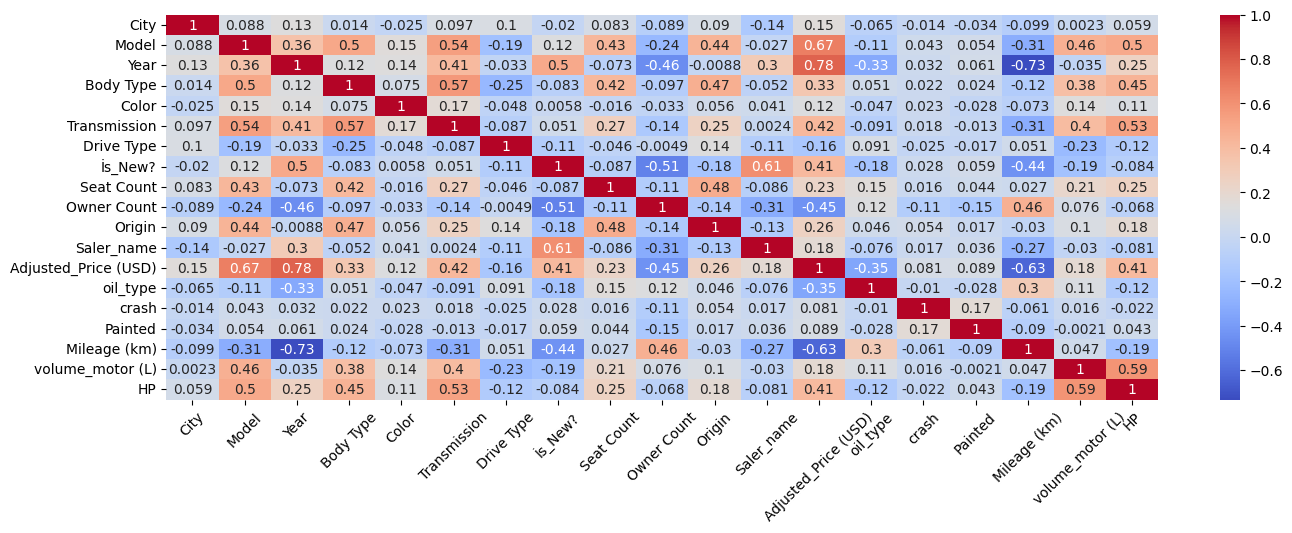

In [117]:
# Create a figure and set the size
plt.figure(figsize=(16, 5))

# Calculate the correlation matrix
corr_matrix = df.corr()

# Generate a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [118]:
# there is neither high pozitife nor high negative correlation between independent variables. so there is no multicollinearity problem

In [119]:
# correlations with target feature

feat_corr = {}

for i in df.columns:
    if i !='Adjusted_Price (USD)':
        feat_corr.update({i:round(df['Adjusted_Price (USD)'].corr(df[i]),3)})
        print('Adjusted_Price (USD)', 'corr with', i, ':', round(df['Adjusted_Price (USD)'].corr(df[i]),3))

Adjusted_Price (USD) corr with City : 0.15
Adjusted_Price (USD) corr with Model : 0.671
Adjusted_Price (USD) corr with Year : 0.776
Adjusted_Price (USD) corr with Body Type : 0.333
Adjusted_Price (USD) corr with Color : 0.123
Adjusted_Price (USD) corr with Transmission : 0.422
Adjusted_Price (USD) corr with Drive Type : -0.157
Adjusted_Price (USD) corr with İs_New? : 0.415
Adjusted_Price (USD) corr with Seat Count : 0.232
Adjusted_Price (USD) corr with Owner Count : -0.448
Adjusted_Price (USD) corr with Origin : 0.258
Adjusted_Price (USD) corr with Saler_name : 0.178
Adjusted_Price (USD) corr with oil_type : -0.353
Adjusted_Price (USD) corr with crash : 0.081
Adjusted_Price (USD) corr with Painted : 0.089
Adjusted_Price (USD) corr with Mileage (km) : -0.628
Adjusted_Price (USD) corr with volume_motor (L) : 0.184
Adjusted_Price (USD) corr with HP : 0.406


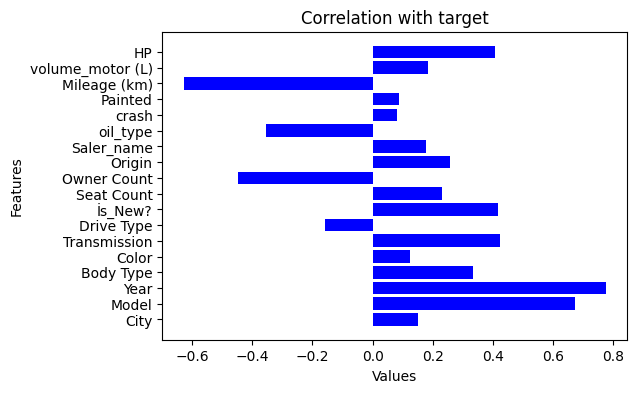

In [120]:
# Create the bar graph
plt.figure(figsize=(6, 4))
plt.barh(list(feat_corr.keys()), list(feat_corr.values()), color='blue')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Features')
plt.title('Correlation with target')

# Show the graph
plt.show()

In [121]:
# Separate columns

X = df.drop(['Adjusted_Price (USD)','crash','Painted'], axis=1)  # drop target and those with very low correlation with target
y = df['Adjusted_Price (USD)']  # Target

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

Mean Squared Error: 16541299.850788819
R-squared: 0.8216468805917968
Coefficients: [ 4.00932541e+02  4.76051779e-01  1.13726031e+03  4.18756154e+03
 -6.92642352e+02 -4.43329251e+03 -1.61493646e+03  3.94550804e+03
  9.75028346e+02 -1.13800641e+02  5.10440667e+03 -3.54702842e+03
 -1.15172662e+04 -5.73980884e-03  1.62432931e+03  9.75762292e+00]
Intercept: -2273529.2948621768


In [130]:
# Initialize the main lookup dictionary
lookup_dict = {}

# Populate the dictionary
for col in df.columns:
    lookup_dict[col] = {}
    for i, val in enumerate(df[col]):
        lookup_val = df_copy[col][i]
        lookup_dict[col][lookup_val] = val

# Example lookups
lookup_values = ['Bakı', 'Ceed',2009, 'Universal','Boz','Mexaniki','Ön','Xeyr', 5 ,1,'Amerika','Şahin','Dizel',255100,1.6,115]  # These are the values you want to look up

# Finding the corresponding values
corresponding_values = {}
for val in lookup_values:
    for col, mapping in lookup_dict.items():
        if val in mapping:
            corresponding_values[val] = mapping[val]

print(f"Corresponding values in df: {corresponding_values}")



Corresponding values in df: {'Bakı': 1, 'Ceed': 9105.811982914605, 2009: 2009, 'Universal': 0.044333529066353496, 'Boz': 0.07751027598355843, 'Mexaniki': 2, 'Ön': 0.8217850851438637, 'Xeyr': 0, 5: 5, 1: 1.0, 'Amerika': 0.17381092190252495, 'Şahin': 0, 'Dizel': 0.5067527891955372, 255100: 255100, 1.6: 1.6, 115: 115}
Predicted Price (USD): [7969.64414239]


In [131]:
print('Predicted Price (USD):',(model.predict(np.array(list(corresponding_values.values())).reshape(1,-1))))

Predicted Price (USD): [7969.64414239]
